As I am using google colab for model building, connecting colab session with gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking if the path is correct

In [ ]:
import os
path= '/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/data_clean.csv'
print(os.path.isfile(path))

True


In [ ]:
import pandas as pd
df = pd.read_csv(path)
df = df[['text','label']]
df['text'] = df['text'].replace('\n',' ', regex=True)
df.rename(columns={'text': 'article', 'label': 'category'}, inplace=True)
df.head()

,article,category
0,ad sales boost time warner profit quarterly p...,business
1,dollar gains on greenspan speech the dollar h...,business
2,yukos unit buyer faces loan claim the owners ...,business
3,high fuel prices hit ba's profits british air...,business
4,pernod takeover talk lifts domecq shares in u...,business


In [ ]:
df['category'].value_counts()

sport            495
business         495
politics         403
entertainment    378
tech             342
Name: category, dtype: int64

Encoding the categorical targets and creating a new column with encoded values

In [ ]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [ ]:
df['label'] = df.category.replace(label_dict)
df['label'].value_counts()

3    495
0    495
2    403
1    378
4    342
Name: label, dtype: int64

Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size= 0.2, 
                                                  random_state=100, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'

df.groupby(['category', 'label', 'data_type']).count()

article
category      label data_type         
business      0     test            99
                    train          396
entertainment 1     test            76
                    train          302
politics      2     test            81
                    train          322
sport         3     test            99
                    train          396
tech          4     test            68
                    train          274

In [ ]:
train, test =  train_test_split(df, test_size = 0.2, random_state = 100,stratify=df.label.values)

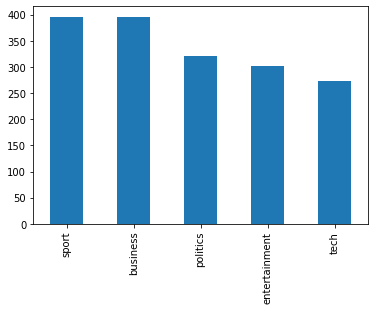

In [ ]:
train['category'].value_counts().plot(kind = 'bar')

In [ ]:
train.head()

,article,category,label,data_type
2108,broadband fuels online expression fast web ac...,tech,4,train
517,famed music director viotti dies conductor ma...,entertainment,1,train
888,crisis 'ahead in social sciences' a national ...,politics,2,train
626,sir paul rocks super bowl crowds sir paul mcc...,entertainment,1,train
978,howard attacks cost of asylum michael howard ...,politics,2,train


In [ ]:
test.head()

,article,category,label,data_type
646,outkast win at mtv europe awards us hip-hop d...,entertainment,1,test
1734,faultless federer has no equal roger federer ...,sport,3,test
830,us composer recreates bach score a us musicol...,entertainment,1,test
542,'landmark movies' of 2004 hailed us film prof...,entertainment,1,test
1268,tories urge 'change at the top' tory delegate...,politics,2,test


Data preprcessing using pretrained transformer architectures (BERT) from tensorflow hub

In [ ]:
import numpy as np
import keras
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
#importing tokenization class from bert official library and other dependencies
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [ ]:
import tokenization

We will now start with the pretrained BERT. In this case we will use the bert_uncased_L-12_H-768_A-12/2 model. We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


In [ ]:
#function defined to encode the text data to a format which the bert model can understand
def bert_encode(texts, tokenizer, max_len):
  all_word_ids = []
  all_masks = []
  all_type_ids = []
  for text in texts:
      text = tokenizer.tokenize(text)
          
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      
      all_word_ids.append(tokens)
      all_masks.append(pad_masks)
      all_type_ids.append(segment_ids)
  
  return np.array(all_word_ids), np.array(all_masks), np.array(all_type_ids)

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train.article.values[0]))

['broadband', 'fuels', 'online', 'expression', 'fast', 'web', 'access', 'is', 'encouraging', 'more', 'people', 'to', 'express', 'themselves', 'online', ',', 'research', 'suggests', '.', 'a', 'quarter', 'of', 'broadband', 'users', 'in', 'britain', 'regularly', 'up', '##load', 'content', 'and', 'have', 'personal', 'sites', ',', 'according', 'to', 'a', 'report', 'by', 'uk', 'think', '-', 'tank', 'demos', '.', 'it', 'said', 'that', 'having', 'an', 'always', '-', 'on', ',', 'fast', 'connection', 'is', 'changing', 'the', 'way', 'people', 'use', 'the', 'internet', '.', 'more', 'than', 'five', 'million', 'households', 'in', 'the', 'uk', 'have', 'broadband', 'and', 'that', 'number', 'is', 'growing', 'fast', '.', 'the', 'demos', 'report', 'looked', 'at', 'the', 'impact', 'of', 'broadband', 'on', 'people', "'", 's', 'net', 'habits', '.', 'it', 'found', 'that', 'more', 'than', 'half', 'of', 'those', 'with', 'broadband', 'logged', 'on', 'to', 'the', 'web', 'before', 'breakfast', '.', 'one', 'in', '

We will now format the text in to input features which the BERT model expects.

In [ ]:
# We'll set sequences to be at most 150 tokens long.
max_len = 150
train_input = bert_encode(train.article.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.article.values, tokenizer, max_len=max_len)

In [ ]:
train_input

(array([[  101, 19595, 20145, ..., 11434,  2111,   102],
        [  101, 15607,  2189, ..., 12687,  2234,   102],
        [  101,  5325,  1005, ...,  2473,  1005,   102],
        ...,
        [  101, 10503,  1005, ...,  2193,  2184,   102],
        [  101,  9433,  2083, ...,  1998,  2027,   102],
        [  101, 12616,  1005, ...,  1011,  1996,   102]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
#Doing 1 hot encoding to our label column ie it will create an array of 5 (since we have 5 classes) and put 1 under the category for each row

#try this also - 1 hot from tensorflow - 
#one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=5)
train_labels

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
#Example on first observation in the training set


print("Sentence : ", train.article.values[0])
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train.article.values[0]))
print("-"*30)
print("Word IDs : ", all_word_ids[0])
print("-"*30)
print("Input Masks : ", all_masks[0])
print("-"*30)
print("Type IDs : ", all_type_ids[0])

Sentence :  broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people's net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the 'me' in media as it

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

Now building A Multi-Class Classifier Model using BERT (BERT layer already imported)

In [ ]:
def build_model(bert_layer, max_len):

  # defining 3 input layers for input_ids, attn_masks and type_ids
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
  
  #defining bert layer and passing the above layers as input
    sequence_output, pooled_output= bert_layer([input_word_ids, input_mask, segment_ids])

  #bert will generate pooled output and sequence output.
  #"pooled_output" for classification tasks on an entire sentence.
  #"sequence_outputs" for token-level output.
    clf_output = pooled_output[:, 0, :]
  
  #these are neural network layers or fully connected newtork for classification
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    return model

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',         

Compiling the model

 

1.   Passing initial learning rate and Adam opimizer as per the official BERT documentation.
2.   Categorical cross entropy as loss function since it is a multi class classification problem
3.   Accuracy as the metric for evaluation

In [ ]:
model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training of the model

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/3
43/43 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.5163 
Epoch 00001: val_accuracy improved from -inf to 0.82840, saving model to model.h5
43/43 [==============================] - 2522s 58s/step - loss: 1.2303 - accuracy: 0.5163 - val_loss: 0.5828 - val_accuracy: 0.8284
Epoch 2/3
43/43 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.8550 
Epoch 00002: val_accuracy improved from 0.82840 to 0.96154, saving model to model.h5
43/43 [==============================] - 2482s 58s/step - loss: 0.4863 - accuracy: 0.8550 - val_loss: 0.2070 - val_accuracy: 0.9615
Epoch 3/3
43/43 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9438 
Epoch 00003: val_accuracy improved from 0.96154 to 0.97929, saving model to model.h5
43/43 [==============================] - 2481s 58s/step - loss: 0.2520 - accuracy: 0.9438 - val_loss: 0.1159 - val_accuracy: 0.9793


In [ ]:
#saving the final model
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/model_bert'
model.save(saved_model_path)


#loading the model from gdrive
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/model_bert')

Model predictions and classification report

In [ ]:
#predicting the test data set

pred = model.predict(test_input)

In [ ]:
pred

array([[1.9846197e-02, 8.3372557e-01, 6.3667528e-02, 4.8925965e-03,
        7.7868134e-02],
       [6.6133663e-03, 2.4175409e-03, 4.3157395e-03, 9.8305953e-01,
        3.5938283e-03],
       [2.7506005e-02, 6.9725037e-01, 8.1957400e-02, 5.1684557e-03,
        1.8811782e-01],
       ...,
       [5.3339842e-04, 1.0936215e-03, 9.9692971e-01, 7.4326270e-04,
        7.0013036e-04],
       [3.8132637e-03, 1.6177733e-03, 4.5456463e-03, 9.8873222e-01,
        1.2910572e-03],
       [1.5885569e-03, 1.2344175e-03, 9.9463981e-01, 1.2706261e-03,
        1.2667115e-03]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds = np.argmax(pred)
print(classification_report(test_y, preds))

In [ ]:
prediction1 = np.argmax(pred[0])
prediction1

1

In [ ]:
label_dict

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [ ]:
actual1 = test.label.values[0]
actual1

1

In [ ]:
actual2 = np.argmax(pred[1])
actual2

3

In [ ]:
verify2 = test.label.values[1]
verify2

3

In [ ]:
prediction3 = np.argmax(pred[400])
prediction3

0

In [ ]:
actual3 = test.label.values[400]
actual3

0

In [ ]:
predictions = np.argmax(pred,axis=1)
predictions

array([1, 3, 1, 1, 2, 3, 4, 3, 0, 2, 2, 1, 3, 1, 3, 3, 0, 1, 2, 1, 1, 3,
       0, 0, 0, 4, 3, 0, 2, 2, 1, 3, 0, 2, 3, 4, 1, 2, 0, 0, 4, 3, 4, 4,
       0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 4, 1, 1, 0, 0, 3, 4, 2, 3, 1, 0, 1,
       2, 0, 1, 4, 1, 0, 2, 4, 0, 2, 3, 3, 2, 0, 1, 2, 3, 4, 1, 0, 3, 3,
       0, 3, 4, 0, 3, 0, 2, 2, 2, 3, 3, 2, 1, 4, 0, 4, 3, 2, 2, 1, 3, 1,
       0, 4, 4, 2, 3, 3, 0, 1, 0, 2, 4, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1,
       0, 3, 4, 3, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 2, 1, 3, 1, 4, 1, 2, 0,
       0, 0, 1, 3, 1, 0, 1, 3, 0, 4, 0, 3, 3, 0, 2, 4, 1, 2, 1, 3, 0, 4,
       0, 4, 2, 3, 4, 4, 4, 1, 1, 1, 4, 1, 1, 3, 0, 1, 2, 0, 3, 0, 0, 0,
       3, 0, 3, 1, 3, 2, 2, 3, 0, 1, 2, 3, 3, 2, 4, 0, 1, 2, 0, 2, 4, 1,
       0, 1, 0, 2, 1, 2, 1, 0, 3, 3, 0, 2, 0, 0, 1, 2, 0, 3, 4, 3, 2, 2,
       4, 0, 3, 3, 2, 1, 2, 1, 4, 0, 2, 2, 1, 4, 0, 4, 1, 4, 0, 2, 2, 2,
       4, 4, 2, 0, 0, 3, 2, 1, 0, 1, 1, 4, 4, 0, 0, 3, 3, 3, 3, 1, 1, 2,
       0, 4, 4, 2, 4, 3, 1, 4, 3, 1, 1, 4, 3, 2, 0,

In [ ]:
actual = test.label.values
actual

array([1, 3, 1, 1, 2, 3, 4, 3, 0, 2, 2, 1, 3, 1, 3, 3, 0, 1, 0, 1, 1, 3,
       0, 0, 0, 4, 3, 0, 2, 2, 1, 3, 0, 2, 3, 4, 1, 2, 0, 0, 4, 3, 4, 4,
       0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 4, 1, 1, 0, 0, 3, 4, 2, 3, 4, 0, 1,
       2, 0, 1, 4, 1, 0, 2, 4, 0, 2, 3, 3, 2, 0, 1, 2, 3, 4, 1, 0, 3, 3,
       0, 3, 4, 0, 3, 0, 0, 2, 2, 3, 3, 2, 1, 4, 0, 4, 3, 2, 2, 1, 3, 1,
       0, 4, 2, 2, 3, 3, 0, 1, 0, 2, 4, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1,
       0, 3, 4, 3, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 2, 1, 3, 1, 4, 1, 2, 0,
       0, 0, 1, 3, 1, 0, 1, 3, 0, 4, 0, 3, 3, 0, 2, 4, 1, 2, 1, 3, 0, 4,
       0, 4, 2, 3, 4, 4, 4, 1, 1, 1, 4, 1, 1, 3, 0, 1, 2, 0, 3, 0, 0, 0,
       4, 0, 3, 1, 3, 2, 2, 3, 0, 1, 2, 3, 3, 2, 4, 0, 1, 2, 0, 2, 4, 1,
       0, 1, 0, 2, 1, 2, 1, 1, 3, 3, 0, 2, 0, 4, 1, 2, 0, 3, 4, 3, 2, 2,
       4, 0, 3, 3, 2, 1, 2, 1, 4, 0, 2, 2, 1, 4, 0, 4, 1, 4, 0, 2, 2, 2,
       4, 4, 2, 0, 0, 3, 2, 1, 0, 1, 1, 4, 4, 0, 4, 3, 3, 3, 3, 1, 1, 2,
       0, 4, 4, 2, 4, 3, 1, 4, 3, 1, 1, 4, 3, 2, 0,

In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        99
           1       0.99      0.99      0.99        76
           2       0.98      0.99      0.98        81
           3       0.99      1.00      0.99        99
           4       0.97      0.93      0.95        68

    accuracy                           0.98       423
   macro avg       0.98      0.97      0.98       423
weighted avg       0.98      0.98      0.98       423



##Another approach using preprocessing model from TF hub

In [ ]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [ ]:
#copied url from tensorflow hub


preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
#bert processing model which doesn't require to manually create the ID's as BERT input
bert_preprocess_model = hub.KerasLayer(preprocess_url)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.


In [ ]:
all_word_ids2 = []
all_masks2 = []
all_type_ids2 = []
def get_sentence_embeding(train):
  for i,text in enumerate(train.article.values):
    text = bert_preprocess_model([text])
    all_word_ids2.append(text["input_word_ids"])
    all_masks2.append(text["input_mask"])
    all_type_ids2.append(text["input_type_ids"])
  return np.array(all_word_ids2), np.array(all_masks2), np.array(all_type_ids2)

In [ ]:
train.article.values[0]

'broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people\'s net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the \'me\' in media as it shifts 

In [ ]:
train_input2 = get_sentence_embeding(train)

This is another approach to get the vector embedding of tokens. This can be passed to the bert model to build the classifier network

In [ ]:
print("Sentence : ", train.article.values[0])
print("-"*30)
print("Word IDs : ", all_word_ids2[0])
print("-"*30)
print("Input Masks : ", all_masks2[0])
print("-"*30)
print("Type IDs : ", all_type_ids2[0])

Sentence :  broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people's net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the 'me' in media as it